In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

In [2]:
df = pd.read_csv(r'c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\Data\merged_tables.csv')
df_knmi = pd.read_csv(r'c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\Data\knmi_data.csv')

In [3]:
print(df.shape)
df.head()

(360, 65)


,Year,Quarter,BedrijfstakkenBranchesSBI2008,ID,BanenMetSeizoenscorrectie_1,BanenZonderSeizoenscorrectie_2,ArbeidsvolumeMetSeizoenscorrectie_3,ArbeidsvolumeZonderSeizoenscorrectie_4,MaandloonInclusiefOverwerk_5,MaandloonExclusiefOverwerk_6,...,CommanditaireVennootschapCV_25,TotaalRechtspersonen_26,BeslotenVennootschapBV_27,NaamlozeVennootschapNV_28,CooperatieveVereniging_29,VerenigingOfStichting_30,Overheid_31,OverigOfOnbekend_32,TotaalOpheffingenVanBedrijven_1,TotaalOprichtingenVanBedrijven_1
0,2008.0,1.0,C Industrie,5043548,12200.0,12186.0,10997.0,10994.0,133808.0,130894.0,...,280.0,18670.0,18225.0,70.0,50.0,80.0,70.0,175.0,875.0,985.0
1,2008.0,1.0,G Handel,5226688,18644.0,18547.0,13323.0,13201.0,111633.0,109999.0,...,1710.0,52685.0,51010.0,65.0,210.0,460.0,0.0,945.0,6005.0,5480.0
2,2008.0,1.0,M Specialistische zakelijke diensten,5407950,7430.0,7401.0,6273.0,6254.0,170279.0,169249.0,...,705.0,56440.0,53935.0,205.0,225.0,1550.0,5.0,515.0,4510.0,6875.0
3,2008.0,1.0,N Verhuur en overige zakelijke diensten,5437514,12249.0,11676.0,7964.0,7570.0,94009.0,92454.0,...,270.0,11380.0,10445.0,15.0,75.0,635.0,5.0,200.0,1085.0,1690.0
4,2008.0,1.0,O Openbaar bestuur en overheidsdiensten,5499134,7430.0,7447.0,6716.0,6732.0,134589.0,133480.0,...,0.0,715.0,15.0,5.0,0.0,45.0,620.0,25.0,10.0,5.0


In [4]:
print(df_knmi.shape)
df_knmi.head()

(60, 6)


,Year_Quarter,airpressure,maximum_temperatures,mean_temperatures,minimum_temperatures,precipitation
0,2008-Q1,10143.000000,91.333333,58.333333,23.666667,758.000000
1,2008-Q2,10143.000000,188.666667,137.000000,80.000000,354.333333
2,2008-Q3,10145.333333,209.000000,163.666667,119.333333,1135.000000
3,2008-Q4,10151.666667,94.000000,64.666667,32.333333,687.666667
4,2009-Q1,10139.000000,65.333333,34.666667,3.333333,523.333333


In [5]:
# Create a combined Year-Quarter column in the format 'YYYY-QX' and insert it as the first column
df.insert(0, 'Year_Quarter', df['Year'].astype(int).astype(str) + '-Q' + df['Quarter'].astype(int).astype(str))

# Drop the now redundant 'Year' and 'Quarter' columns
df = df.drop(columns=['Year', 'Quarter'])

# Sort the DataFrame by 'BedrijfstakkenBranchesSBI2008' and 'Year_Quarter' for better chronological order
df = df.sort_values(by=['BedrijfstakkenBranchesSBI2008', 'Year_Quarter']).reset_index(drop=True)

# Display the modified DataFrame with the new column and sorting
print(df.shape)
df.head()

(360, 64)


,Year_Quarter,BedrijfstakkenBranchesSBI2008,ID,BanenMetSeizoenscorrectie_1,BanenZonderSeizoenscorrectie_2,ArbeidsvolumeMetSeizoenscorrectie_3,ArbeidsvolumeZonderSeizoenscorrectie_4,MaandloonInclusiefOverwerk_5,MaandloonExclusiefOverwerk_6,PrijsindexArbeid_1,...,CommanditaireVennootschapCV_25,TotaalRechtspersonen_26,BeslotenVennootschapBV_27,NaamlozeVennootschapNV_28,CooperatieveVereniging_29,VerenigingOfStichting_30,Overheid_31,OverigOfOnbekend_32,TotaalOpheffingenVanBedrijven_1,TotaalOprichtingenVanBedrijven_1
0,2008-Q1,C Industrie,5043548,12200.0,12186.0,10997.0,10994.0,133808.0,130894.0,78.5,...,280.0,18670.0,18225.0,70.0,50.0,80.0,70.0,175.0,875.0,985.0
1,2008-Q2,C Industrie,5043762,12218.0,12238.0,11005.0,11006.0,134681.0,131518.0,79.8,...,275.0,18645.0,18200.0,70.0,50.0,80.0,70.0,175.0,775.0,1400.0
2,2008-Q3,C Industrie,5043976,12210.0,12194.0,11013.0,11012.0,136175.0,133501.0,80.5,...,270.0,18755.0,18315.0,65.0,45.0,80.0,75.0,170.0,615.0,1245.0
3,2008-Q4,C Industrie,5044190,12180.0,12178.0,10984.0,10985.0,140258.0,137145.0,81.0,...,275.0,18885.0,18440.0,65.0,45.0,85.0,75.0,170.0,655.0,1180.0
4,2009-Q1,C Industrie,5044408,12053.0,12040.0,10852.0,10848.0,137254.0,134947.0,82.0,...,305.0,19270.0,18830.0,65.0,45.0,85.0,75.0,170.0,840.0,725.0


In [6]:
# Correct column name
target_column = 'Ziekteverzuimpercentage_1'

# Ensure the column exists before proceeding
if target_column not in df.columns:
    raise KeyError(f"Column '{target_column}' not found in DataFrame. Available columns: {list(df.columns)}")

# Create lagged and lead features grouped by 'BedrijfstakkenBranchesSBI2008'
df[f'{target_column}_lag_1'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(1)
df[f'{target_column}_lag_2'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(2)
df[f'{target_column}_lag_3'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(3)
df[f'{target_column}_lag_4'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(4)

df[f'{target_column}_lead_1'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(-1)
df[f'{target_column}_lead_2'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(-2)
df[f'{target_column}_lead_3'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(-3)
df[f'{target_column}_lead_4'] = df.groupby('BedrijfstakkenBranchesSBI2008')[target_column].shift(-4)

# Display the resulting DataFrame to verify the new columns
print(df.shape)
print(df.head())


(360, 72)
  Year_Quarter BedrijfstakkenBranchesSBI2008       ID  \
0      2008-Q1                   C Industrie  5043548   
1      2008-Q2                   C Industrie  5043762   
2      2008-Q3                   C Industrie  5043976   
3      2008-Q4                   C Industrie  5044190   
4      2009-Q1                   C Industrie  5044408   

   BanenMetSeizoenscorrectie_1  BanenZonderSeizoenscorrectie_2  \
0                      12200.0                         12186.0   
1                      12218.0                         12238.0   
2                      12210.0                         12194.0   
3                      12180.0                         12178.0   
4                      12053.0                         12040.0   

   ArbeidsvolumeMetSeizoenscorrectie_3  \
0                              10997.0   
1                              11005.0   
2                              11013.0   
3                              10984.0   
4                              10852.0  

In [7]:
# Assume df and df_knmi are already loaded as per your examples
# Step 1: Create a DataFrame of unique industries from df
industries = df[['BedrijfstakkenBranchesSBI2008']].drop_duplicates()

# Step 2: Perform a Cartesian product to expand df_knmi across all industries
expanded_knmi = df_knmi.merge(industries, how='cross')

# Step 3: Merge the expanded df_knmi with the main df based on 'Year_Quarter'
df = df.merge(expanded_knmi, on=['Year_Quarter', 'BedrijfstakkenBranchesSBI2008'], how='left')

# Display the result
print(df.shape)
df.head()

(360, 77)


,Year_Quarter,BedrijfstakkenBranchesSBI2008,ID,BanenMetSeizoenscorrectie_1,BanenZonderSeizoenscorrectie_2,ArbeidsvolumeMetSeizoenscorrectie_3,ArbeidsvolumeZonderSeizoenscorrectie_4,MaandloonInclusiefOverwerk_5,MaandloonExclusiefOverwerk_6,PrijsindexArbeid_1,...,Ziekteverzuimpercentage_1_lag_4,Ziekteverzuimpercentage_1_lead_1,Ziekteverzuimpercentage_1_lead_2,Ziekteverzuimpercentage_1_lead_3,Ziekteverzuimpercentage_1_lead_4,airpressure,maximum_temperatures,mean_temperatures,minimum_temperatures,precipitation
0,2008-Q1,C Industrie,5043548,12200.0,12186.0,10997.0,10994.0,133808.0,130894.0,78.5,...,NaN,4.8,4.4,5.2,5.4,10143.000000,91.333333,58.333333,23.666667,758.000000
1,2008-Q2,C Industrie,5043762,12218.0,12238.0,11005.0,11006.0,134681.0,131518.0,79.8,...,NaN,4.4,5.2,5.4,4.8,10143.000000,188.666667,137.000000,80.000000,354.333333
2,2008-Q3,C Industrie,5043976,12210.0,12194.0,11013.0,11012.0,136175.0,133501.0,80.5,...,NaN,5.2,5.4,4.8,4.9,10145.333333,209.000000,163.666667,119.333333,1135.000000
3,2008-Q4,C Industrie,5044190,12180.0,12178.0,10984.0,10985.0,140258.0,137145.0,81.0,...,NaN,5.4,4.8,4.9,5.6,10151.666667,94.000000,64.666667,32.333333,687.666667
4,2009-Q1,C Industrie,5044408,12053.0,12040.0,10852.0,10848.0,137254.0,134947.0,82.0,...,5.4,4.8,4.9,5.6,5.5,10139.000000,65.333333,34.666667,3.333333,523.333333


In [8]:
# Define a function to label COVID-19 years
def label_covid_period(row):
    if row['Year_Quarter'].startswith('2020') or row['Year_Quarter'].startswith('2021') or row['Year_Quarter'].startswith('2022'):
        return 1
    else:
        return 0

# Apply the function to create the covid_19 column
df['covid_19'] = df.apply(label_covid_period, axis=1)

# Display the DataFrame to confirm the changes
print(df[['Year_Quarter', 'covid_19']].head())

  Year_Quarter  covid_19
0      2008-Q1         0
1      2008-Q2         0
2      2008-Q3         0
3      2008-Q4         0
4      2009-Q1         0


In [9]:
df.tail()

,Year_Quarter,BedrijfstakkenBranchesSBI2008,ID,BanenMetSeizoenscorrectie_1,BanenZonderSeizoenscorrectie_2,ArbeidsvolumeMetSeizoenscorrectie_3,ArbeidsvolumeZonderSeizoenscorrectie_4,MaandloonInclusiefOverwerk_5,MaandloonExclusiefOverwerk_6,PrijsindexArbeid_1,...,Ziekteverzuimpercentage_1_lead_1,Ziekteverzuimpercentage_1_lead_2,Ziekteverzuimpercentage_1_lead_3,Ziekteverzuimpercentage_1_lead_4,airpressure,maximum_temperatures,mean_temperatures,minimum_temperatures,precipitation,covid_19
355,2021-Q4,Q Gezondheids- en welzijnszorg,5549972,21749.0,21821.0,14893.0,15009.0,151843.0,151409.0,100.0,...,8.9,7.5,7.1,8.0,10148.000000,111.666667,81.333333,48.000000,920.000000,1
356,2022-Q1,Q Gezondheids- en welzijnszorg,5550190,21864.0,21898.0,14984.0,14982.0,151740.0,151410.0,101.4,...,7.5,7.1,8.0,NaN,10208.333333,101.666667,64.666667,24.000000,682.333333,1
357,2022-Q2,Q Gezondheids- en welzijnszorg,5550404,21906.0,21975.0,15010.0,15012.0,153670.0,153370.0,103.3,...,7.1,8.0,NaN,NaN,10165.666667,185.666667,134.666667,75.333333,747.666667,1
358,2022-Q3,Q Gezondheids- en welzijnszorg,5550618,21913.0,21749.0,15058.0,14954.0,156571.0,156275.0,103.1,...,8.0,NaN,NaN,NaN,10169.333333,231.666667,177.333333,114.666667,561.666667,1
359,2022-Q4,Q Gezondheids- en welzijnszorg,5550832,22041.0,22093.0,15147.0,15245.0,155405.0,155029.0,105.1,...,NaN,NaN,NaN,NaN,10133.333333,118.000000,85.333333,48.000000,744.666667,1


In [10]:
df.info(verbose=True, show_counts=True) #verbose is true because it otherwise doesn't output the entire list of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 78 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Year_Quarter                            360 non-null    object 
 1   BedrijfstakkenBranchesSBI2008           360 non-null    object 
 2   ID                                      360 non-null    int64  
 3   BanenMetSeizoenscorrectie_1             360 non-null    float64
 4   BanenZonderSeizoenscorrectie_2          360 non-null    float64
 5   ArbeidsvolumeMetSeizoenscorrectie_3     360 non-null    float64
 6   ArbeidsvolumeZonderSeizoenscorrectie_4  360 non-null    float64
 7   MaandloonInclusiefOverwerk_5            360 non-null    float64
 8   MaandloonExclusiefOverwerk_6            360 non-null    float64
 9   PrijsindexArbeid_1                      360 non-null    float64
 10  JaarmutatiePrijsVanArbeid_2             360 non-null    float6

## Correlation

In [11]:
# Select only numeric columns (float and int types) from the DataFrame
df_numeric = df.select_dtypes(include=['float', 'int'])

# Ensure the target column exists in the filtered numeric DataFrame
if 'Ziekteverzuimpercentage_1' in df_numeric.columns:
    # Calculate the correlation matrix and extract correlations with the target column
    df_num_corr = df_numeric.corr()['Ziekteverzuimpercentage_1']
    
    # Filter for features with strong correlations (absolute correlation > 0.5)
    golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
    
    # Print the results if there are any strongly correlated features
    print("There are {} strongly correlated values with ziekteverzuim:\n{}".format(len(golden_features_list), golden_features_list))
else:
    print("The target column 'Ziekteverzuimpercentage_1' is not in the numeric columns.")


There are 36 strongly correlated values with ziekteverzuim:
Ziekteverzuimpercentage_1           1.000000
Ziekteverzuimpercentage_1_lead_4    0.952152
Ziekteverzuimpercentage_1_lag_4     0.952152
Ziekteverzuimpercentage_1_lead_1    0.903304
Ziekteverzuimpercentage_1_lag_1     0.903304
Ziekteverzuimpercentage_1_lag_3     0.889546
Ziekteverzuimpercentage_1_lead_3    0.889546
Ziekteverzuimpercentage_1_lag_2     0.821502
Ziekteverzuimpercentage_1_lead_2    0.821502
k_500Tot1000WerkzamePersonen_13     0.563431
k_1000Tot2000WerkzamePersonen_14    0.525830
k_2Tot10WerkzamePersonen_18        -0.504035
k_10Tot50WerkzamePersonen_4        -0.512224
NatuurlijkePersonen_12             -0.512863
TotaalNatuurlijkePersonen_21       -0.512863
k_1WerkzaamPersoon_2               -0.513227
k_2Tot10WerkzamePersonen_3         -0.536381
TotaalOprichtingenVanBedrijven_1   -0.554077
TotaalBedrijven_1                  -0.555176
k_0Tot50WerkzamePersonen_10        -0.555727
k_0Tot50WerkzamePersonen_16        -0.55

In [12]:
# Initialize a dictionary to store correlation results
correlation_results_by_industry = {}

# Define the target variables
target_columns = [
    'Ziekteverzuimpercentage_1',
    'Ziekteverzuimpercentage_1_lead_1',
    'Ziekteverzuimpercentage_1_lead_2',
    'Ziekteverzuimpercentage_1_lead_3',
    'Ziekteverzuimpercentage_1_lead_4'
]

# Set correlation threshold
correlation_threshold = 0.7

# Group by industry
for industry, group_df in df.groupby('BedrijfstakkenBranchesSBI2008'):
    # Select numeric columns
    group_df_numeric = group_df.select_dtypes(include=[float, int])
    
    # Initialize a dictionary to store correlation results for this industry
    industry_correlation_results = {}
    
    for target in target_columns:
        # Check if the target exists in the group
        if target in group_df_numeric.columns:
            # Calculate correlation matrix
            corr_matrix = group_df_numeric.corr()
            target_corr = corr_matrix[target]
            
            # Retain features with strong correlation
            strongly_correlated_features = target_corr[abs(target_corr) > correlation_threshold].sort_values(ascending=False)
            
            # Store the results
            industry_correlation_results[target] = strongly_correlated_features
    
    # Store results for this industry
    if industry_correlation_results:
        correlation_results_by_industry[industry] = industry_correlation_results

# Output the results
print("Correlation Analysis Results:")
for industry, results in correlation_results_by_industry.items():
    print(f"Industry: {industry}")
    for target, correlations in results.items():
        print(f"  Target: {target}")
        print(f"  Strong correlations:\n{correlations}\n")


Correlation Analysis Results:
Industry: C Industrie
  Target: Ziekteverzuimpercentage_1
  Strong correlations:
Ziekteverzuimpercentage_1           1.000000
Ziekteverzuimpercentage_1_lead_4    0.802920
Ziekteverzuimpercentage_1_lag_4     0.802920
Rechtspersonen_13                   0.710406
TotaalRechtspersonen_26             0.710406
BeslotenVennootschapBV_27           0.701034
Name: Ziekteverzuimpercentage_1, dtype: float64

  Target: Ziekteverzuimpercentage_1_lead_1
  Strong correlations:
Ziekteverzuimpercentage_1_lead_1    1.000000
Ziekteverzuimpercentage_1_lag_3     0.802920
BeslotenVennootschapBV_27           0.731406
Rechtspersonen_13                   0.722919
TotaalRechtspersonen_26             0.722919
Name: Ziekteverzuimpercentage_1_lead_1, dtype: float64

  Target: Ziekteverzuimpercentage_1_lead_2
  Strong correlations:
Ziekteverzuimpercentage_1_lead_2    1.000000
Ziekteverzuimpercentage_1_lag_2     0.802920
BeslotenVennootschapBV_27           0.730152
Rechtspersonen_13     

In [13]:
correlation_results_by_industry

{'C Industrie': {'Ziekteverzuimpercentage_1': Ziekteverzuimpercentage_1           1.000000
  Ziekteverzuimpercentage_1_lead_4    0.802920
  Ziekteverzuimpercentage_1_lag_4     0.802920
  Rechtspersonen_13                   0.710406
  TotaalRechtspersonen_26             0.710406
  BeslotenVennootschapBV_27           0.701034
  Name: Ziekteverzuimpercentage_1, dtype: float64,
  'Ziekteverzuimpercentage_1_lead_1': Ziekteverzuimpercentage_1_lead_1    1.000000
  Ziekteverzuimpercentage_1_lag_3     0.802920
  BeslotenVennootschapBV_27           0.731406
  Rechtspersonen_13                   0.722919
  TotaalRechtspersonen_26             0.722919
  Name: Ziekteverzuimpercentage_1_lead_1, dtype: float64,
  'Ziekteverzuimpercentage_1_lead_2': Ziekteverzuimpercentage_1_lead_2    1.000000
  Ziekteverzuimpercentage_1_lag_2     0.802920
  BeslotenVennootschapBV_27           0.730152
  Rechtspersonen_13                   0.725993
  TotaalRechtspersonen_26             0.725993
  TotaalOprichtingenVan

In [14]:
import os

# Create a directory to store the datasets if it doesn't exist
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# Define the target variables
target_columns = [
    'Ziekteverzuimpercentage_1',
    'Ziekteverzuimpercentage_1_lead_1',
    'Ziekteverzuimpercentage_1_lead_2',
    'Ziekteverzuimpercentage_1_lead_3',
    'Ziekteverzuimpercentage_1_lead_4'
]

# Filter the data for 'C Industrie'
industry = 'C Industrie'
industry_data = df[df['BedrijfstakkenBranchesSBI2008'] == industry]

# Process each target variable
for target in target_columns:
    # Check if the target has correlation results for this industry
    if industry in correlation_results_by_industry and target in correlation_results_by_industry[industry]:
        # Get the features strongly correlated with the current target
        correlated_features = correlation_results_by_industry[industry][target].index.tolist()
        
        # Add the target variable itself
        correlated_features.append(target)
        
        # Add 'Year_Quarter' as it should always be included
        correlated_features.append('Year_Quarter')
        
        # Ensure only valid columns are selected (features that exist in the DataFrame)
        valid_columns = [col for col in correlated_features if col in industry_data.columns]
        
        # Filter the data to include only strongly correlated features
        filtered_data = industry_data[valid_columns]
        
        # Remove duplicate column names (if any)
        filtered_data = filtered_data.loc[:, ~filtered_data.columns.duplicated()]
        
        # Save the filtered dataset as a CSV file
        output_path = os.path.join(output_folder, f"{target}.csv")
        filtered_data.to_csv(output_path, index=False)
        print(f"Dataset for {target} (C Industrie) saved to {output_path}.")


Dataset for Ziekteverzuimpercentage_1 (C Industrie) saved to data\Ziekteverzuimpercentage_1.csv.
Dataset for Ziekteverzuimpercentage_1_lead_1 (C Industrie) saved to data\Ziekteverzuimpercentage_1_lead_1.csv.
Dataset for Ziekteverzuimpercentage_1_lead_2 (C Industrie) saved to data\Ziekteverzuimpercentage_1_lead_2.csv.
Dataset for Ziekteverzuimpercentage_1_lead_3 (C Industrie) saved to data\Ziekteverzuimpercentage_1_lead_3.csv.
Dataset for Ziekteverzuimpercentage_1_lead_4 (C Industrie) saved to data\Ziekteverzuimpercentage_1_lead_4.csv.


In [19]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Function to compute VIF for a DataFrame
def calculate_vif(df, threshold=10):
    """
    Calculate VIF for features in a DataFrame, removing features with infinite VIF iteratively.

    Parameters:
        df (DataFrame): DataFrame containing only numeric features.
        threshold (float): VIF threshold above which features are flagged.

    Returns:
        DataFrame: DataFrame containing features and their VIF values below the threshold.
    """
    df = df.copy()
    while True:
        vif_data = pd.DataFrame()
        vif_data['Feature'] = df.columns
        vif_data['VIF'] = [
            variance_inflation_factor(df.values, i) for i in range(df.shape[1])
        ]
        max_vif = vif_data['VIF'].max()

        if max_vif == float('inf'):
            feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
            print(f"Removing feature with infinite VIF: {feature_to_remove}")
            df = df.drop(columns=[feature_to_remove])
        else:
            break
    return vif_data[vif_data['VIF'] < threshold]

# Select numeric columns for VIF computation
numeric_columns = df.select_dtypes(include=[float, int]).columns.tolist()

# Ensure there are no missing or infinite values
df_numeric = df[numeric_columns].replace([np.inf, -np.inf], np.nan).dropna()

# Drop constant columns
df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]

# Compute VIF and filter
vif_filtered = calculate_vif(df_numeric)
print(vif_filtered)



c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_10


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: NatuurlijkePersonen_12


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: Rechtspersonen_13
     Feature       VIF
71  covid_19  7.615143


In [20]:
# Function to compute VIF for a DataFrame with logging
def calculate_vif_with_logging(df, threshold=10):
    """
    Calculate VIF for features in a DataFrame, removing features with infinite VIF iteratively.

    Parameters:
        df (DataFrame): DataFrame containing only numeric features.
        threshold (float): VIF threshold above which features are flagged.

    Returns:
        DataFrame: DataFrame containing features and their VIF values below the threshold.
    """
    df = df.copy()
    removed_features = []
    while True:
        vif_data = pd.DataFrame()
        vif_data['Feature'] = df.columns
        vif_data['VIF'] = [
            variance_inflation_factor(df.values, i) for i in range(df.shape[1])
        ]
        max_vif = vif_data['VIF'].max()

        if max_vif == float('inf'):
            feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
            print(f"Removing feature with infinite VIF: {feature_to_remove}")
            removed_features.append(feature_to_remove)
            df = df.drop(columns=[feature_to_remove])
        else:
            break
    print("\nRemoved features with infinite VIF:")
    print(removed_features)
    return vif_data[vif_data['VIF'] < threshold]

# Use the function to compute VIF
vif_filtered = calculate_vif_with_logging(df_numeric)
print(vif_filtered)


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_10


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: NatuurlijkePersonen_12


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: Rechtspersonen_13

Removed features with infinite VIF:
['k_0Tot50WerkzamePersonen_10', 'k_0Tot250WerkzamePersonen_11', 'NatuurlijkePersonen_12', 'Rechtspersonen_13']
     Feature       VIF
71  covid_19  7.615143


In [21]:
# Access the index (column names) from the correlation Series
column_names = golden_features_list.index.tolist()

# Get the column names that meet the VIF and lag condition
vif_filtered_columns = vif_filtered['Feature'].tolist()

# Combine correlation-filtered and VIF-filtered columns
selected_columns = list(set(column_names) & set(vif_filtered_columns))

# Add additional necessary columns
additional_columns = ['Year_Quarter', 'BedrijfstakkenBranchesSBI2008']
all_columns = selected_columns + additional_columns

# Filter the DataFrame
df_filtered = df[all_columns]

# Display the filtered DataFrame
df_filtered.head()


,Year_Quarter,BedrijfstakkenBranchesSBI2008
0,2008-Q1,C Industrie
1,2008-Q2,C Industrie
2,2008-Q3,C Industrie
3,2008-Q4,C Industrie
4,2009-Q1,C Industrie


In [22]:
df_final = df_filtered.dropna()
print(df_final.shape)
df_final.head()

(360, 2)


,Year_Quarter,BedrijfstakkenBranchesSBI2008
0,2008-Q1,C Industrie
1,2008-Q2,C Industrie
2,2008-Q3,C Industrie
3,2008-Q4,C Industrie
4,2009-Q1,C Industrie


In [23]:
df_final.to_json('data/df_final.json')

## Ziekteverzuim

count    360.000000
mean       4.410556
std        1.204009
min        2.300000
25%        3.300000
50%        4.550000
75%        5.300000
max        8.900000
Name: Ziekteverzuimpercentage_1, dtype: float64


<Figure size 900x800 with 0 Axes>

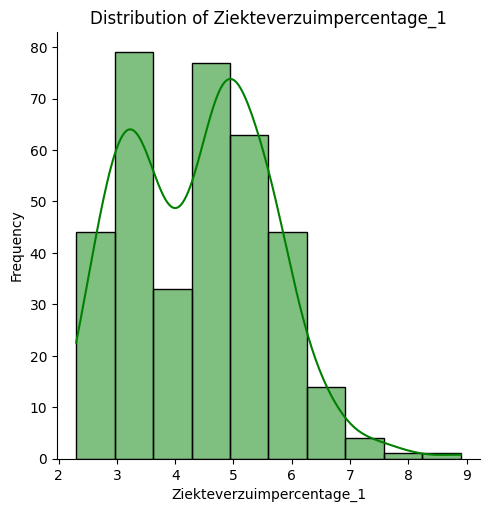

In [26]:
# Print the description of the Ziekteverzuimpercentage_1 column
print(df['Ziekteverzuimpercentage_1'].describe())

# Plot the distribution with seaborn
plt.figure(figsize=(9, 8))
sns.displot(df['Ziekteverzuimpercentage_1'], color='g', bins=10, kde=True)
plt.title('Distribution of Ziekteverzuimpercentage_1')
plt.xlabel('Ziekteverzuimpercentage_1')
plt.ylabel('Frequency')
plt.show()

C:\Users\c.hakker\AppData\Local\Temp\ipykernel_15020\1440039962.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


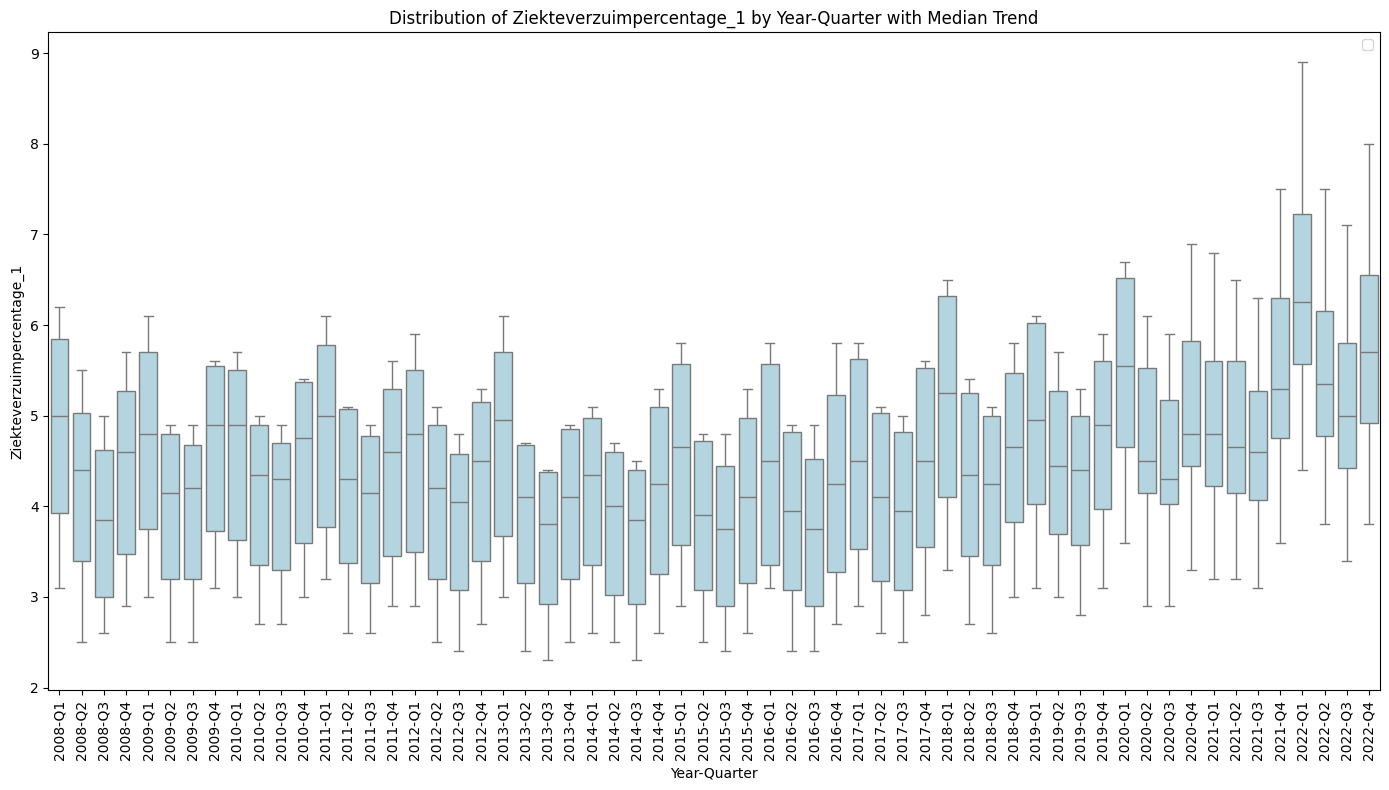

In [28]:
# Plot the data
plt.figure(figsize=(14, 8))

# Boxplot
sns.boxplot(data=df, x='Year_Quarter', y='Ziekteverzuimpercentage_1', color='lightblue')

# Adding labels and title
plt.title('Distribution of Ziekteverzuimpercentage_1 by Year-Quarter with Median Trend')
plt.xlabel('Year-Quarter')
plt.ylabel('Ziekteverzuimpercentage_1')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()

## Numerical data distribution

In [29]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [30]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,ID,BanenMetSeizoenscorrectie_1,BanenZonderSeizoenscorrectie_2,ArbeidsvolumeMetSeizoenscorrectie_3,ArbeidsvolumeZonderSeizoenscorrectie_4,MaandloonInclusiefOverwerk_5,MaandloonExclusiefOverwerk_6,PrijsindexArbeid_1,JaarmutatiePrijsVanArbeid_2,LoonkostenPerGewerktUur_3,...,Ziekteverzuimpercentage_1_lead_1,Ziekteverzuimpercentage_1_lead_2,Ziekteverzuimpercentage_1_lead_3,Ziekteverzuimpercentage_1_lead_4,airpressure,maximum_temperatures,mean_temperatures,minimum_temperatures,precipitation,covid_19
0,5043548,12200.0,12186.0,10997.0,10994.0,133808.0,130894.0,78.5,3.9,73.2,...,4.8,4.4,5.2,5.4,10143.000000,91.333333,58.333333,23.666667,758.000000,0
1,5043762,12218.0,12238.0,11005.0,11006.0,134681.0,131518.0,79.8,5.0,74.5,...,4.4,5.2,5.4,4.8,10143.000000,188.666667,137.000000,80.000000,354.333333,0
2,5043976,12210.0,12194.0,11013.0,11012.0,136175.0,133501.0,80.5,5.5,75.1,...,5.2,5.4,4.8,4.9,10145.333333,209.000000,163.666667,119.333333,1135.000000,0
3,5044190,12180.0,12178.0,10984.0,10985.0,140258.0,137145.0,81.0,5.5,75.6,...,5.4,4.8,4.9,5.6,10151.666667,94.000000,64.666667,32.333333,687.666667,0
4,5044408,12053.0,12040.0,10852.0,10848.0,137254.0,134947.0,82.0,4.5,76.7,...,4.8,4.9,5.6,5.5,10139.000000,65.333333,34.666667,3.333333,523.333333,0


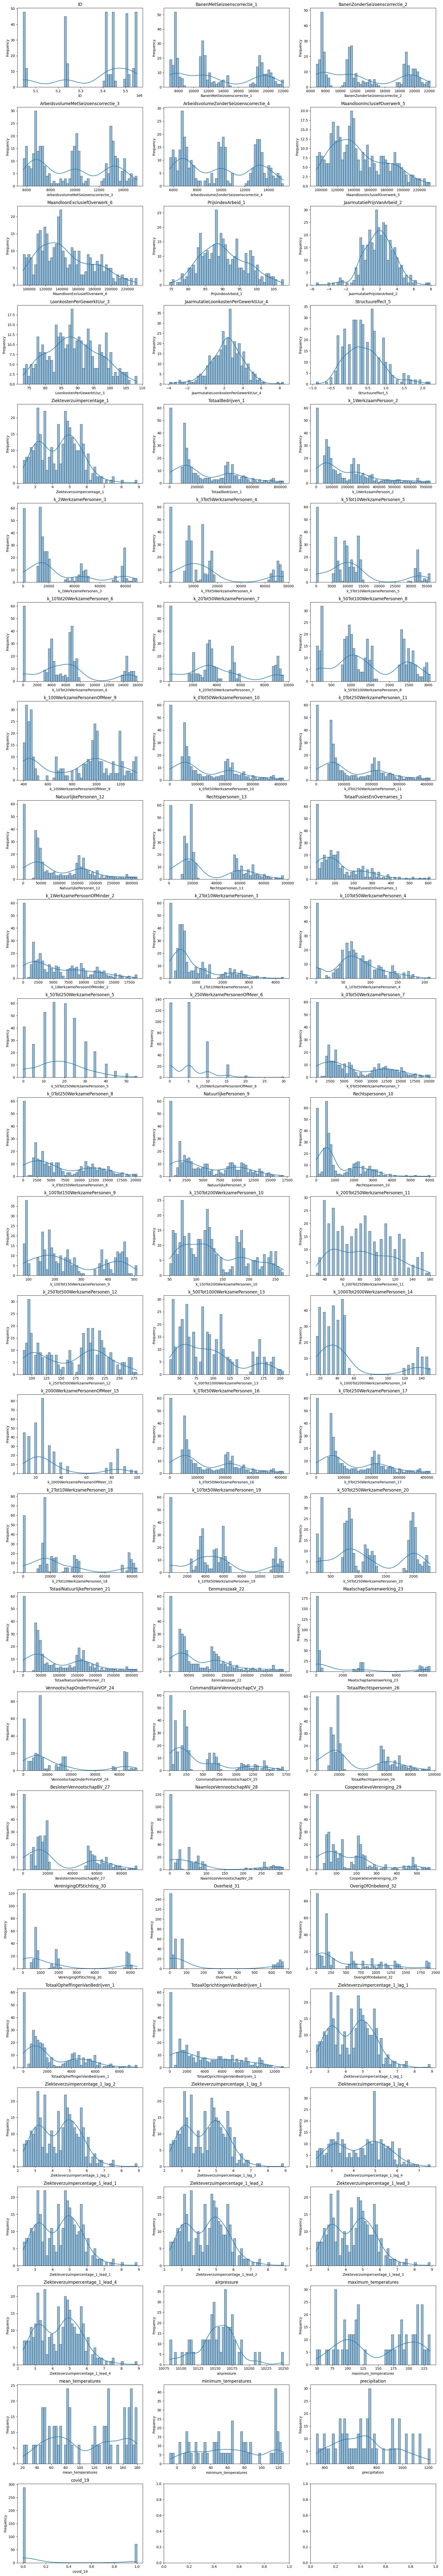

In [31]:
# Calculate number of rows and columns for subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(df_num.columns) - 1) // num_cols + 1  # Number of rows needed

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each numeric column
for i, col in enumerate(df_num.columns):
    ax = axes[i]
    sns.histplot(df_num[col], bins=50, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

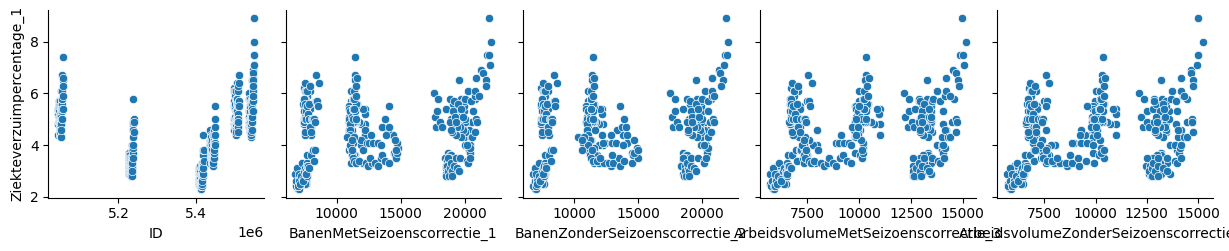

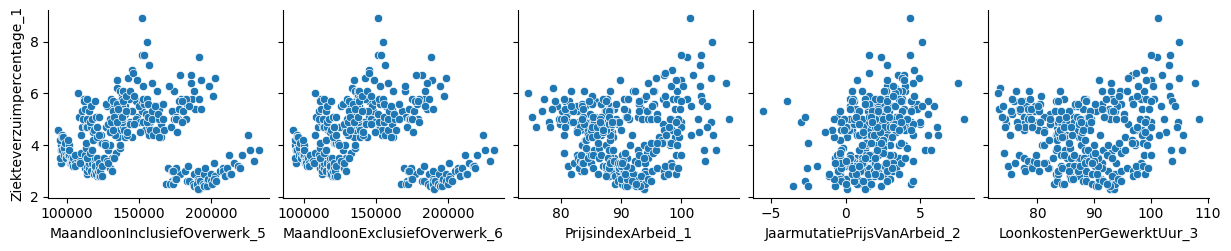

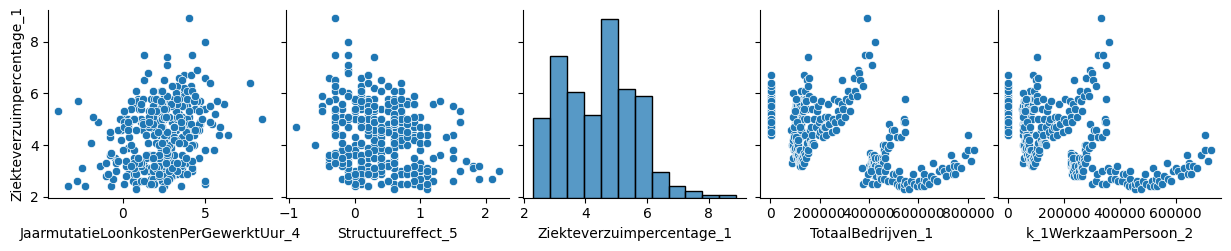

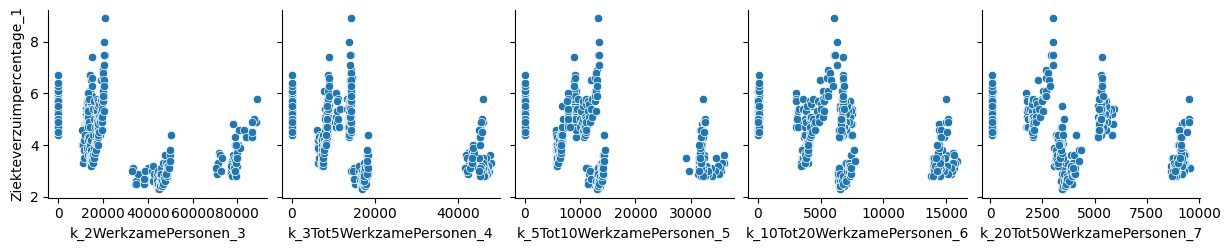

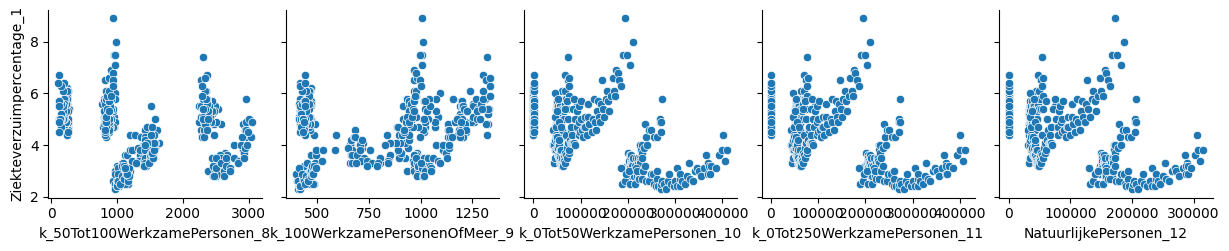

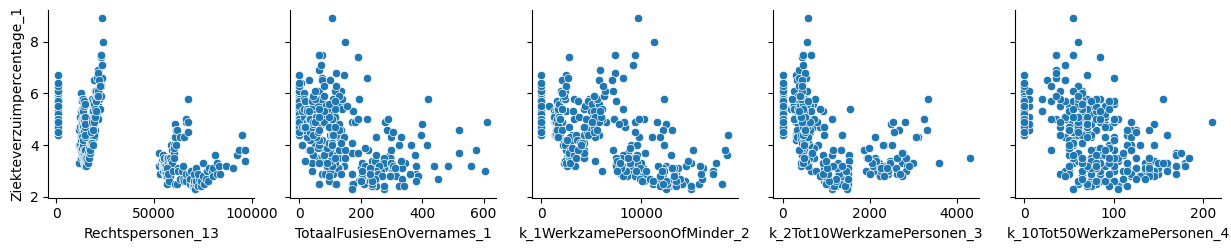

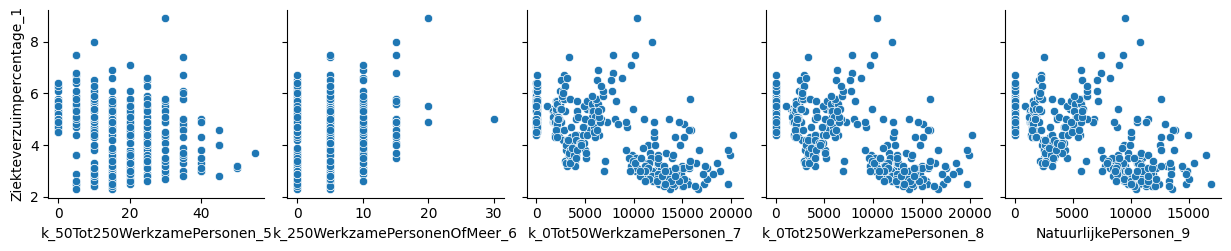

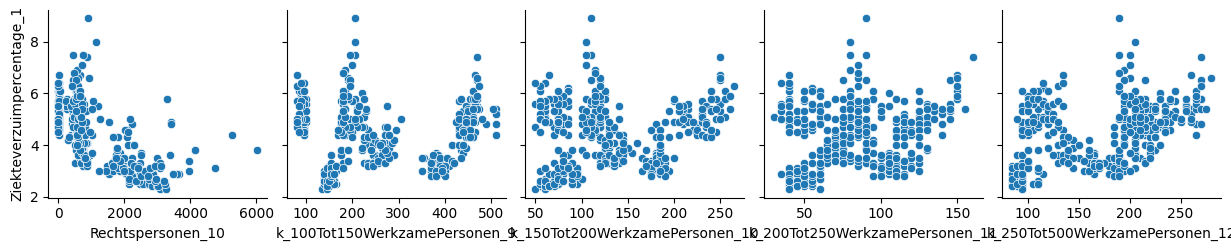

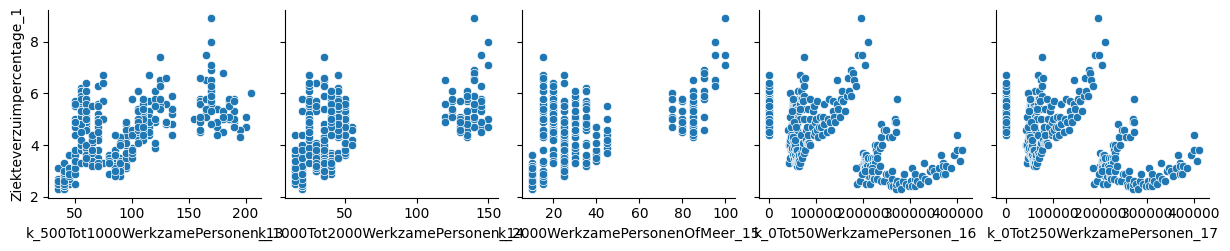

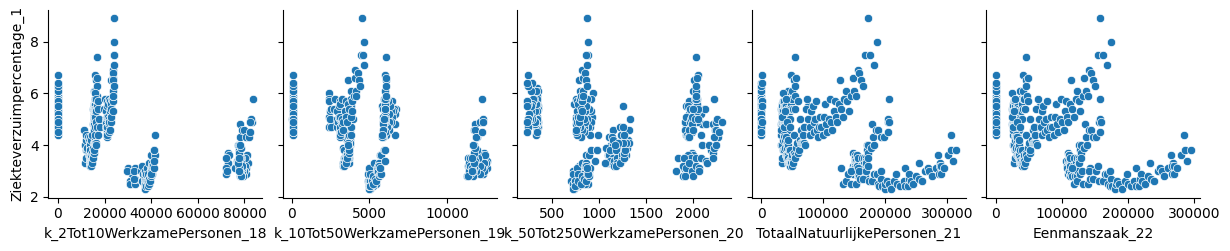

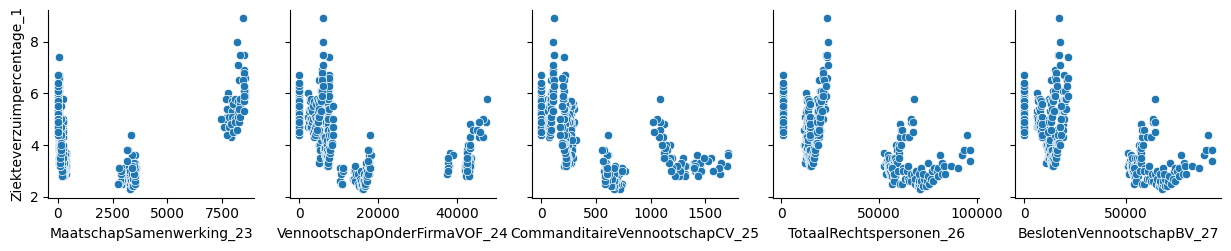

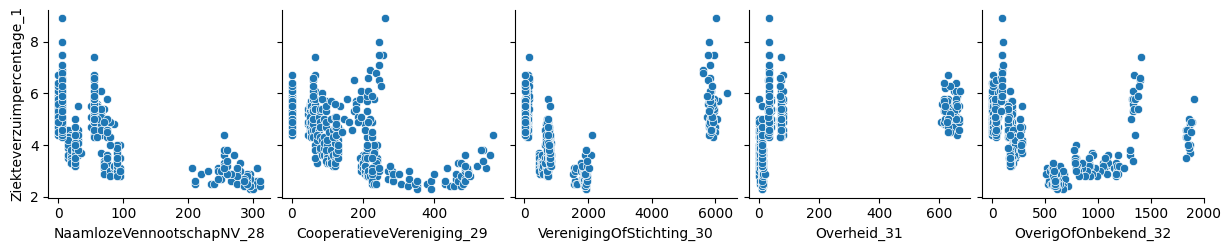

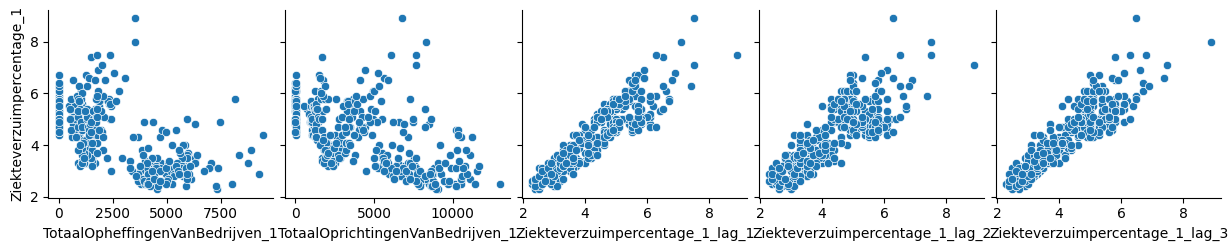

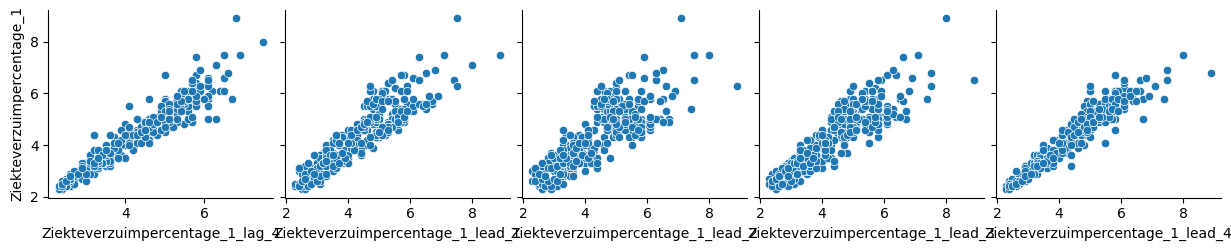

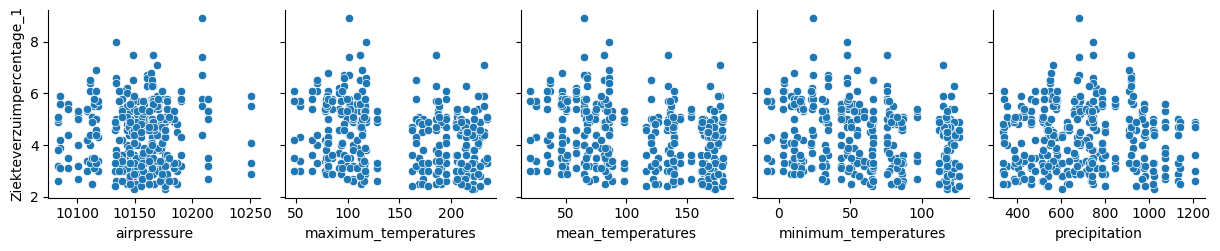

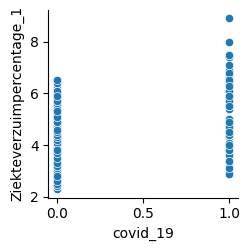

In [32]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Ziekteverzuimpercentage_1'])

In [33]:
# Define the columns for which we want lagged correlations
columns_to_lag = [
    'airpressure', 'maximum_temperatures', 'mean_temperatures', 
    'minimum_temperatures', 'precipitation', 'covid_19'
]

# Create lagged variables for each column in `columns_to_lag`
for col in columns_to_lag:
    df[f'{col}_lag_1'] = df[col].shift(1)
    df[f'{col}_lag_2'] = df[col].shift(2)

# Recompute numeric-only DataFrame to include new lagged columns
df_numeric = df.select_dtypes(include=[float, int])

# Calculate correlations for the primary column of interest and its lags
correlation_columns = columns_to_lag + [f"{col}_lag_1" for col in columns_to_lag] + [f"{col}_lag_2" for col in columns_to_lag]
correlations = df_numeric.corr()['Ziekteverzuimpercentage_1'][correlation_columns]

print("Correlations with ned_Ziekteverzuimpercentage_1:")
print(correlations)

Correlations with ned_Ziekteverzuimpercentage_1:
airpressure                   0.014439
maximum_temperatures         -0.229022
mean_temperatures            -0.233051
minimum_temperatures         -0.240921
precipitation                -0.014687
covid_19                      0.326563
airpressure_lag_1            -0.006740
maximum_temperatures_lag_1   -0.000493
mean_temperatures_lag_1       0.014248
minimum_temperatures_lag_1    0.036620
precipitation_lag_1           0.129534
covid_19_lag_1                0.303164
airpressure_lag_2             0.070646
maximum_temperatures_lag_2    0.260428
mean_temperatures_lag_2       0.260126
minimum_temperatures_lag_2    0.252561
precipitation_lag_2           0.047905
covid_19_lag_2                0.286723
Name: Ziekteverzuimpercentage_1, dtype: float64


In [34]:
# Set VIF threshold
vif_threshold = 10

# Initialize a dictionary to store VIF results
vif_results_by_industry = {}

# Function to iteratively remove features with infinite VIF
def calculate_vif_with_removal(features_df):
    features_df = features_df.copy()
    while True:
        vif_data = pd.DataFrame()
        vif_data['Feature'] = features_df.columns
        vif_data['VIF'] = [
            variance_inflation_factor(features_df.values, i) for i in range(features_df.shape[1])
        ]
        
        # Check for infinite VIF values
        max_vif = vif_data['VIF'].max()
        if max_vif == float('inf'):
            # Remove the feature with the highest VIF
            feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
            print(f"Removing feature with infinite VIF: {feature_to_remove}")
            features_df = features_df.drop(columns=[feature_to_remove])
        else:
            break
    
    return vif_data

# Iterate over industries identified in correlation analysis
for industry, correlation_results in correlation_results_by_industry.items():
    # Initialize a dictionary to store VIF results for this industry
    industry_vif_results = {}
    
    for target, correlations in correlation_results.items():
        # Extract the strongly correlated features
        correlated_features = correlations.index.tolist()
        
        # Prepare data for VIF calculation
        features_for_vif = df[df['BedrijfstakkenBranchesSBI2008'] == industry][correlated_features]
        
        # Handle missing or infinite values
        features_for_vif = features_for_vif.replace([np.inf, -np.inf], np.nan).dropna()

        if not features_for_vif.empty and features_for_vif.shape[1] > 1:  # Ensure there are enough features
            # Calculate VIF with removal of problematic features
            vif_data = calculate_vif_with_removal(features_for_vif)
            
            # Retain features with VIF <= threshold or containing 'lag'
            selected_features = vif_data[
                (vif_data['VIF'] <= vif_threshold) | (vif_data['Feature'].str.contains('lag'))
            ]
            
            # Store the results
            industry_vif_results[target] = selected_features
    
    # Store VIF results for this industry
    if industry_vif_results:
        vif_results_by_industry[industry] = industry_vif_results

# Output the results
print("VIF Analysis Results:")
for industry, results in vif_results_by_industry.items():
    print(f"Industry: {industry}")
    for target, vif_data in results.items():
        print(f"  Target: {target}")
        print(f"  VIF Data:\n{vif_data}\n")


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDri

Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: NatuurlijkePersonen_12
Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11
Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_16
Removing feature with infinite VIF: TotaalRechtspersonen_26


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDri

Removing feature with infinite VIF: TotaalNatuurlijkePersonen_21
Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11
Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_16
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDri

Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_16
Removing feature with infinite VIF: NatuurlijkePersonen_12
Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_11
Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_16
Removing feature with infinite VIF: TotaalNatuurlijkePersonen_21
Removing feature with infinite VIF: TotaalRechtspersonen_26


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDri

Removing feature with infinite VIF: TotaalNatuurlijkePersonen_21
Removing feature with infinite VIF: k_0Tot250WerkzamePersonen_17
Removing feature with infinite VIF: k_0Tot50WerkzamePersonen_10
Removing feature with infinite VIF: Rechtspersonen_13


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: Rechtspersonen_13
Removing feature with infinite VIF: TotaalRechtspersonen_26
Removing feature with infinite VIF: TotaalRechtspersonen_26
VIF Analysis Results:
Industry: C Industrie
  Target: Ziekteverzuimpercentage_1
  VIF Data:
                           Feature        VIF
2  Ziekteverzuimpercentage_1_lag_4  415.05252

  Target: Ziekteverzuimpercentage_1_lead_1
  VIF Data:
                           Feature         VIF
1  Ziekteverzuimpercentage_1_lag_3  264.298339

  Target: Ziekteverzuimpercentage_1_lead_2
  VIF Data:
                           Feature         VIF
1  Ziekteverzuimpercentage_1_lag_2  265.351069

  Target: Ziekteverzuimpercentage_1_lead_3
  VIF Data:
                           Feature         VIF
1  Ziekteverzuimpercentage_1_lag_1  293.490904

  Target: Ziekteverzuimpercentage_1_lead_4
  VIF Data:
                           Feature         VIF
1  Ziekteverzuimpercentage_1_lag_4 

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
